# Compare Speaker Diarization Pipelines

In this notebook, differen speaker diarization pipelines will be compared in terms of performance. The following pipelines for speaker representation will be compared:

- Speechbrains [pretrained ECAPA-TDNN](https://huggingface.co/speechbrain/spkrec-ecapa-voxceleb) model with default settings as in `model.encode_batch()`
- The pretrained [UniSpeech-SAT](https://huggingface.co/docs/transformers/model_doc/unispeech-sat) model in the `transformers` package with default settings
- The pretrained [WavLM](https://huggingface.co/docs/transformers/model_doc/wavlm) model in the `transformers` package with default settings

All models receive preprocessed audio signals from the `transformers` [Wav2Vec2FeatureExtractor](https://huggingface.co/docs/transformers/model_doc/wav2vec2#transformers.Wav2Vec2FeatureExtractor) with padding and normalization enabled. Audio segments that are longer than 20s are split into equal sized subsegments and encoded separately. Afterwards, the encodings are averaged over the subsegments (thus, there is one embedding vector for each segment in the end). The embeddings are normalized.

For speaker representation clustering, three methods will be compared:
- Spectral clustering (SC)
- Agglomerative clustering (AC)
- K-means (KM)

all from the `sklearn.cluster` package with default settings and four clusters (equal to the amount of speakers).

The pipelines will be compared using four metrics (diarization error rate [DER], diarization error rate with skipped overlap [DER skip], coverage, and purity) as described [here](https://pyannote.github.io/pyannote-metrics/reference.html#diarization).

In [1]:
from rttm import read_rttm
from pyannote.core import Annotation, Timeline, Segment
from pyannote.metrics.diarization import DiarizationErrorRate, DiarizationCoverage, DiarizationPurity
import seaborn as sns
import pandas as pd
import numpy as np
import os


In [2]:
RESULTS = ["speechbrain-ecapa-tdnn",
           "transformers-unisat", "transformers-wavlm"]


In [3]:
CLUSTER_METHODS = ["sc", "ac", "km"]


In [4]:
FILE_INDICES = list(range(16))


In [5]:
diarization_der = DiarizationErrorRate(collar=0.25)
diarization_der_skip = DiarizationErrorRate(collar=0.25, skip_overlap=True)
diarization_coverage = DiarizationCoverage(collar=0.25)
diarization_purity = DiarizationPurity(collar=0.25)


In [6]:
def convert_rttm_annotation(rttm_seq):
    annotation = Annotation()
    for seg in rttm_seq.sequence:
        annotation[Segment(seg.tbeg, seg.tbeg+seg.tdur)] = seg.name

    return annotation


In [32]:
results_df = {"metric": [], "method": [], "cluster": [], "value": []}

method_labels = {
    "speechbrain-ecapa-tdnn": "sb_ecapa_tdnn",
    "transformers-unisat": "tr_unisat",
    "transformers-wavlm": "tr_wavlm"
}

for res_dir in RESULTS:
    for cm in CLUSTER_METHODS:
        for i in FILE_INDICES:
            res_rttm_seq = read_rttm(os.path.join('results',res_dir,f"{cm}_{method_labels[res_dir]}_ami_sample_{i}.rttm"))
            ref_rttm_seq = read_rttm(os.path.join(
                "results", "reference", f"ref_ami_micro_test_sample_{i}.rttm"))
            res_annotation = convert_rttm_annotation(res_rttm_seq)
            ref_annotation = convert_rttm_annotation(ref_rttm_seq)
            der = diarization_der(ref_annotation, res_annotation)
            der_skip = diarization_der_skip(ref_annotation, res_annotation)
            coverage = diarization_coverage(
                ref_annotation, res_annotation)
            purity = diarization_purity(
                ref_annotation, res_annotation)

            results_df["metric"] = results_df["metric"] + \
                ["der", "der_skip", "coverage", "purity"]
            results_df["method"] = results_df["method"] + \
                [method_labels[res_dir]] * 4
            results_df["cluster"] = results_df["cluster"] + [cm] * 4
            results_df["value"] = results_df["value"] + \
                [der, der_skip, coverage, purity]

results_df = pd.DataFrame(results_df)

/Users/evaviviani/opt/anaconda3/lib/python3.9/site-packages/pyannote/metrics/utils.py:183: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


In [35]:
def select_min_max(group):
    if pd.DataFrame(group).reset_index()["metric"].apply(lambda x: x in ["der", "der_skip"]).all():
        return np.min(group)
    else:
        return np.max(group)


In [36]:
mean_results_df = results_df.groupby(
    ["metric", "method", "cluster"]).aggregate(np.mean)

mean_best_results_dict = mean_results_df.groupby(
    ["cluster", "metric"]).aggregate(select_min_max).to_dict()["value"]


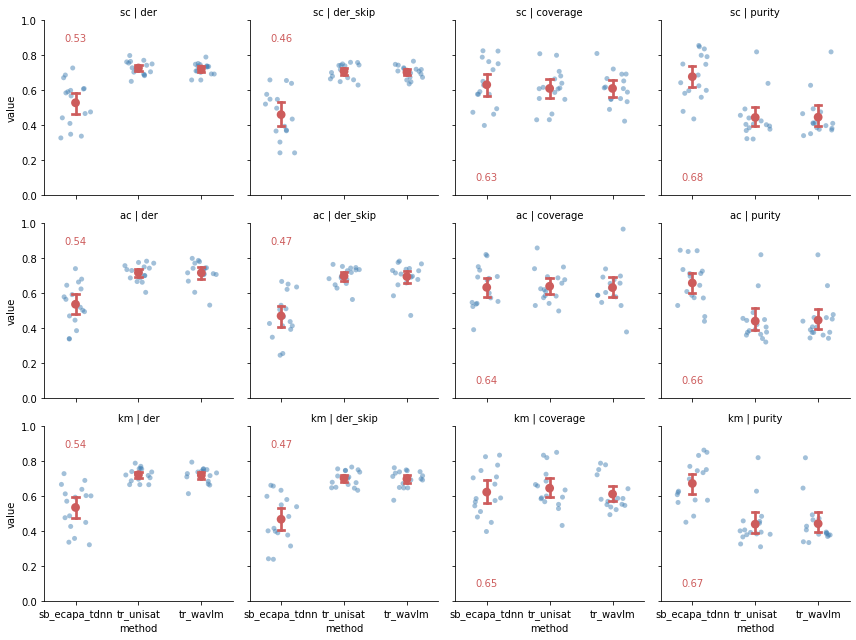

In [37]:
grid = sns.FacetGrid(data=results_df, col="metric", row="cluster")

grid.map(sns.stripplot, "method", "value", color="steelblue",
         order=method_labels.values(), alpha=0.5, jitter=0.25, zorder=1)
grid.map(sns.pointplot, "method", "value", color="indianred", join=False,
         order=method_labels.values(), estimator=np.mean, capsize=0.1, zorder=2)

grid.set_titles(col_template="{col_name}", row_template="{row_name}")
grid.set(ylim=(0.0, 1.0), yticks=np.linspace(0.0, 1.0, 6))

best_pos = {"der": (0, 0.9), "der_skip": (0, 0.9),
            "coverage": (0, 0.1), "purity": (0, 0.1)}

for col in grid.axes:
    for row in col:
        metric = tuple(row.title.get_text().split(" | "))
        best = round(mean_best_results_dict[metric], 2)
        row.annotate(text=best, xy=best_pos[metric[1]],
                     ha='center', va='center', color="indianred")

grid.savefig("sd_comparison.pdf")
grid.savefig("sd_comparison.png")


The comparison shows that Speechbrain's ECAPA-TDNN model outperforms the UniSpeech-SAT and WavLM models in terms of diarization error rate (DER; with and without overlapping segments). The three clustering algorithms perform similarly on all three speaker representation models, although spectral clustering slightly outperforms agglomerative clustering and k-means. Absolutely, the performance of the best combination is moderate and indicates need for improvement. Both coverage and purity are around the same values for ECAPA-TDNN indicating neither over or undersegmentation. For UniSpeech-SAT and WavLM, purity is lower than coverge indicating slight [undersegmentation](https://pyannote.github.io/pyannote-metrics/reference.html#purity-and-coverage) (i.e., different speaker segments are assigned to the same speaker). Overall, Speechbrain's ECAPA-TDNN model combined with spectral clustering seems to be the preferred choice for encoding speaker representations.

In [117]:
models_overlap_df = {"file_id": [], "identification_ratio": [],
              "duration": [], "is_overlap": [], "overlap_ratio": [], "model": []}

for x in RESULTS:
    for i in FILE_INDICES:
       # print(method_labels[x],i)
        ref_rttm_seq = read_rttm(os.path.join(
            "results", "reference", f"ref_ami_micro_test_sample_{i}.rttm"))
        ref_annotation = convert_rttm_annotation(ref_rttm_seq)
        res_rttm_seq = read_rttm(os.path.join(
            "results", x, f"sc_{method_labels[x]}_ami_sample_{i}.rttm"))
        res_annotation = convert_rttm_annotation(res_rttm_seq)

        mapping = diarization_der.optimal_mapping(ref_annotation, res_annotation)

        ref_overlap_timeline = ref_annotation.get_timeline().get_overlap()

        for segment, track, label in ref_annotation.itertracks(yield_label=True):
            if not [key for key, val in mapping.items() if val == label]:
                print(f"{segment},{track},{label} is empty, skipping ...")
                continue
                
            mapped_spk = [key for key, val in mapping.items() if val == label][0]
            spk_timeline = res_annotation.subset(mapped_spk).get_timeline()
            identification_dur = 0.0
            for seg_pair in spk_timeline.co_iter(Timeline([segment])):
                identification_seg = seg_pair[0] & seg_pair[1]
                identification_dur += identification_seg.duration

            overlap_dur = 0
            for seg_pair in ref_overlap_timeline.co_iter(Timeline([segment])):
                overlap_seg = seg_pair[0] & seg_pair[1]
                overlap_dur += overlap_seg.duration

            models_overlap_df["file_id"].append(i)
            models_overlap_df["identification_ratio"].append(
                identification_dur/segment.duration)
            models_overlap_df["duration"].append(segment.duration)
            models_overlap_df["is_overlap"].append(overlap_dur > 0)
            models_overlap_df["overlap_ratio"].append(overlap_dur/segment.duration)
            models_overlap_df["model"].append(method_labels[x])

models_overlap_df = pd.DataFrame(models_overlap_df)


sb_ecapa_tdnn 0
sb_ecapa_tdnn 1
sb_ecapa_tdnn 2
sb_ecapa_tdnn 3
sb_ecapa_tdnn 4
sb_ecapa_tdnn 5
sb_ecapa_tdnn 6
sb_ecapa_tdnn 7
sb_ecapa_tdnn 8
sb_ecapa_tdnn 9
sb_ecapa_tdnn 10
sb_ecapa_tdnn 11
sb_ecapa_tdnn 12
sb_ecapa_tdnn 13
sb_ecapa_tdnn 14
sb_ecapa_tdnn 15
tr_unisat 0
tr_unisat 1
tr_unisat 2
tr_unisat 3
tr_unisat 4
tr_unisat 5
tr_unisat 6
tr_unisat 7
tr_unisat 8
[ 00:00:16.300 -->  00:00:16.730],_,C is empty, skipping ...
[ 00:00:45.440 -->  00:00:45.920],_,C is empty, skipping ...
[ 00:03:17.270 -->  00:03:18.270],_,C is empty, skipping ...
[ 00:07:35.150 -->  00:07:35.870],_,C is empty, skipping ...
[ 00:09:20.880 -->  00:09:23.230],_,C is empty, skipping ...
[ 00:09:43.650 -->  00:09:46.020],_,C is empty, skipping ...
[ 00:10:56.910 -->  00:10:57.440],_,C is empty, skipping ...
[ 00:12:45.810 -->  00:12:46.950],_,C is empty, skipping ...
[ 00:13:15.870 -->  00:13:16.410],_,C is empty, skipping ...
[ 00:14:41.420 -->  00:14:42.010],_,C is empty, skipping ...
[ 00:14:43.740 -->  

In [38]:
overlap_df = {"file_id": [], "identification_ratio": [],
              "duration": [], "is_overlap": [], "overlap_ratio": []}

for i in FILE_INDICES:
    ref_rttm_seq = read_rttm(os.path.join(
        "results", "reference", f"ref_ami_micro_test_sample_{i}.rttm"))
    ref_annotation = convert_rttm_annotation(ref_rttm_seq)
    res_rttm_seq = read_rttm(os.path.join(
        "results", "speechbrain-ecapa-tdnn", f"sc_sb_ecapa_tdnn_ami_sample_{i}.rttm"))
    res_annotation = convert_rttm_annotation(res_rttm_seq)

    mapping = diarization_der.optimal_mapping(ref_annotation, res_annotation)

    ref_overlap_timeline = ref_annotation.get_timeline().get_overlap()

    for segment, track, label in ref_annotation.itertracks(yield_label=True):
        mapped_spk = [key for key, val in mapping.items() if val == label][0]
        spk_timeline = res_annotation.subset(mapped_spk).get_timeline()
        identification_dur = 0.0
        for seg_pair in spk_timeline.co_iter(Timeline([segment])):
            identification_seg = seg_pair[0] & seg_pair[1]
            identification_dur += identification_seg.duration

        overlap_dur = 0
        for seg_pair in ref_overlap_timeline.co_iter(Timeline([segment])):
            overlap_seg = seg_pair[0] & seg_pair[1]
            overlap_dur += overlap_seg.duration

        overlap_df["file_id"].append(i)
        overlap_df["identification_ratio"].append(
            identification_dur/segment.duration)
        overlap_df["duration"].append(segment.duration)
        overlap_df["is_overlap"].append(overlap_dur > 0)
        overlap_df["overlap_ratio"].append(overlap_dur/segment.duration)

overlap_df = pd.DataFrame(overlap_df)


In [126]:
overlap_df = models_overlap_df[models_overlap_df["model"]=="sb_ecapa_tdnn"]

In [127]:
total_overlap_df = overlap_df.groupby(["file_id"]).identification_ratio.aggregate(
    [lambda x: np.mean(x > 0.99), lambda x: np.mean(x < 0.01)]).reset_index()


In [128]:
color_palette = ["indianred", "steelblue"]


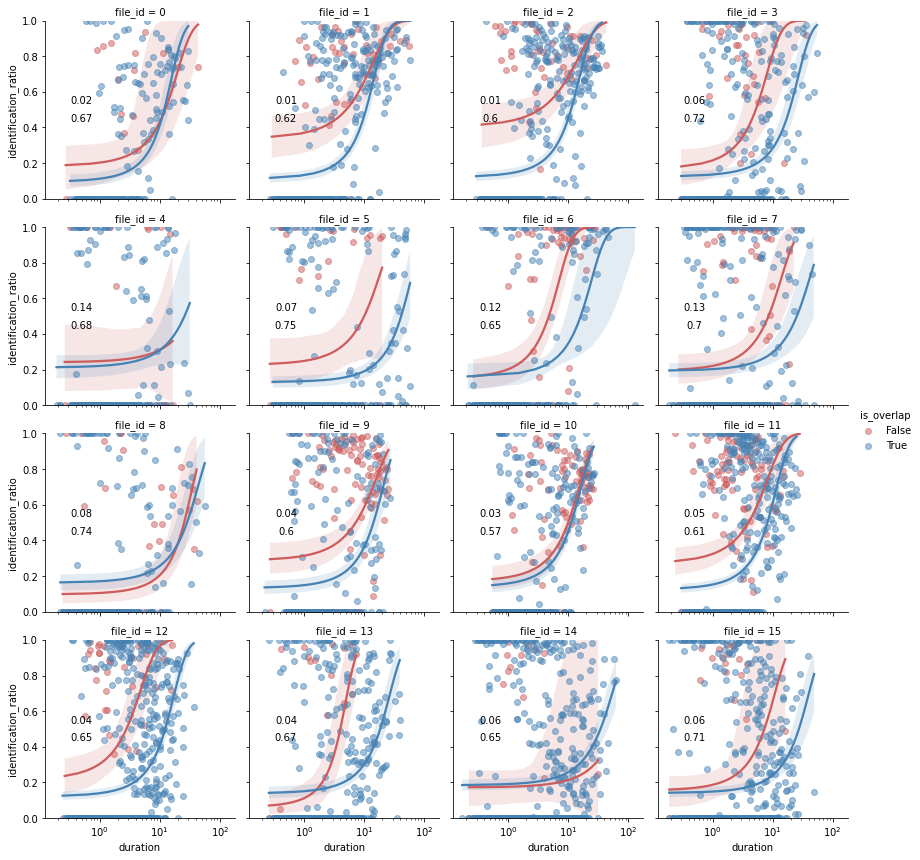

In [41]:
grid = sns.FacetGrid(data=overlap_df, col="file_id",
                     hue="is_overlap", col_wrap=4, palette=color_palette)

grid.map(sns.regplot, "duration", "identification_ratio", logistic=True,
         scatter_kws={"alpha": 0.5})

grid.set(ylim=(0.0, 1.0), xscale="log")

for i, col in enumerate(grid.axes):
    col.annotate(text=round(total_overlap_df.iloc[:, 1][i], 2), xy=(
        0.5, 0.55), ha='center', va='center')
    col.annotate(text=round(total_overlap_df.iloc[:, 2][i], 2), xy=(
        0.5, 0.45), ha='center', va='center')

grid.add_legend()

grid.savefig("sd_identification_duration.pdf")
grid.savefig("sd_identification_duration.png")


The figure shows the ratio of correctly assigned speaker time (identification ratio) by the ECAPA-TDNN + SC combination for ground truth segments (points = segments) as a function of the log duration of the ground truth segments. The two colors indicate whether the ground truth segment overlaps with *any* other ground truth segment. The regression lines indicate fitted logistic functions. The annotated numbers show the ratio of segments with an identification ratio of above 0.99 (top label) and below 0.01 (bottom label). 

This figure suggests that the pipeline can identify speakers much better for longer speech segments which do not overlap with other speech segments.

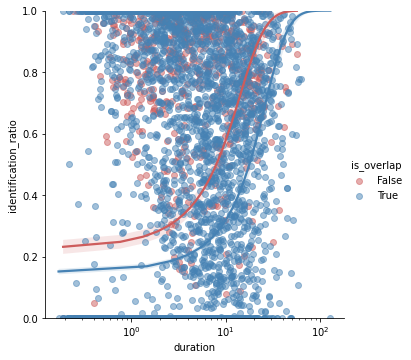

In [92]:
plt = sns.lmplot(x="duration", y="identification_ratio", hue="is_overlap",
                 data=overlap_df, logistic=True, palette=color_palette,
                 scatter_kws={"alpha": 0.5})
plt.set(ylim=(0.0, 1.0), xscale="log")


In [43]:
complete_or_none_df = overlap_df.groupby(["is_overlap"]).identification_ratio.aggregate(
    [lambda x: np.mean(x > 0.99), lambda x: np.mean(x < 0.01)]).reset_index()
complete_or_none_df.columns = ["is_overlap", "ratio_complete", "ratio_none"]
complete_or_none_df

,is_overlap,ratio_complete,ratio_none
0,False,0.057735,0.558845
1,True,0.055974,0.678944


This table indicates that ground truth speech segments which overlap are much more often not identified at all but not more often completely identified compared to non-overlapping segments.

/Users/evaviviani/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/evaviviani/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/evaviviani/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/evaviviani/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


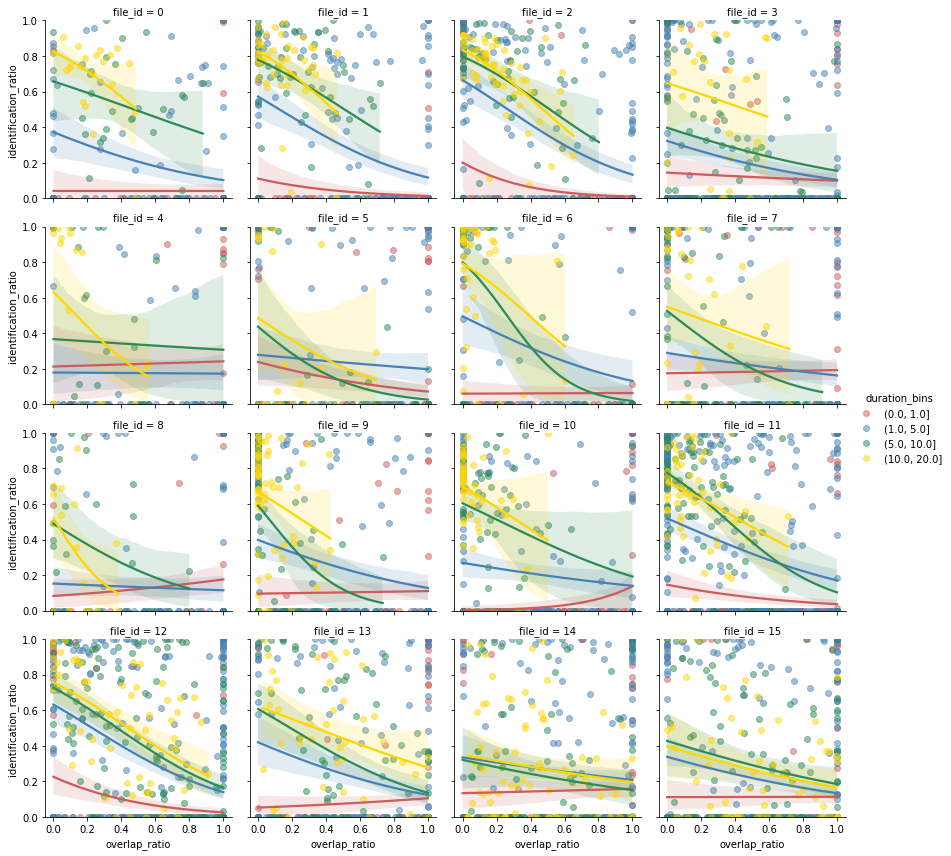

In [44]:
overlap_df["duration_bins"] = pd.cut(overlap_df["duration"], [0.0, 1.0, 5.0, 10.0, 20.0])

grid = sns.FacetGrid(data=overlap_df, hue="duration_bins", col="file_id", col_wrap=4, palette=["indianred", "steelblue", "seagreen", "gold"])

grid.map(sns.regplot, "overlap_ratio", "identification_ratio", logistic=True,
         scatter_kws={"alpha": 0.5})

grid.set(ylim=(0.0, 1.0))

grid.add_legend()

grid.savefig("sd_identification_overlap.pdf")
grid.savefig("sd_identification_overlap.png")


This figure shows the identification ratio as a function of the ratio of overlap of ground truth segments with any other ground truth segment. The colors indicate different duration intervals (in s) and the lines fitted logistic functions.

It can be seen that speakers are less correctly identified when speech segments have more overlap with other segments. This effect is more pronounced for short speech segments.

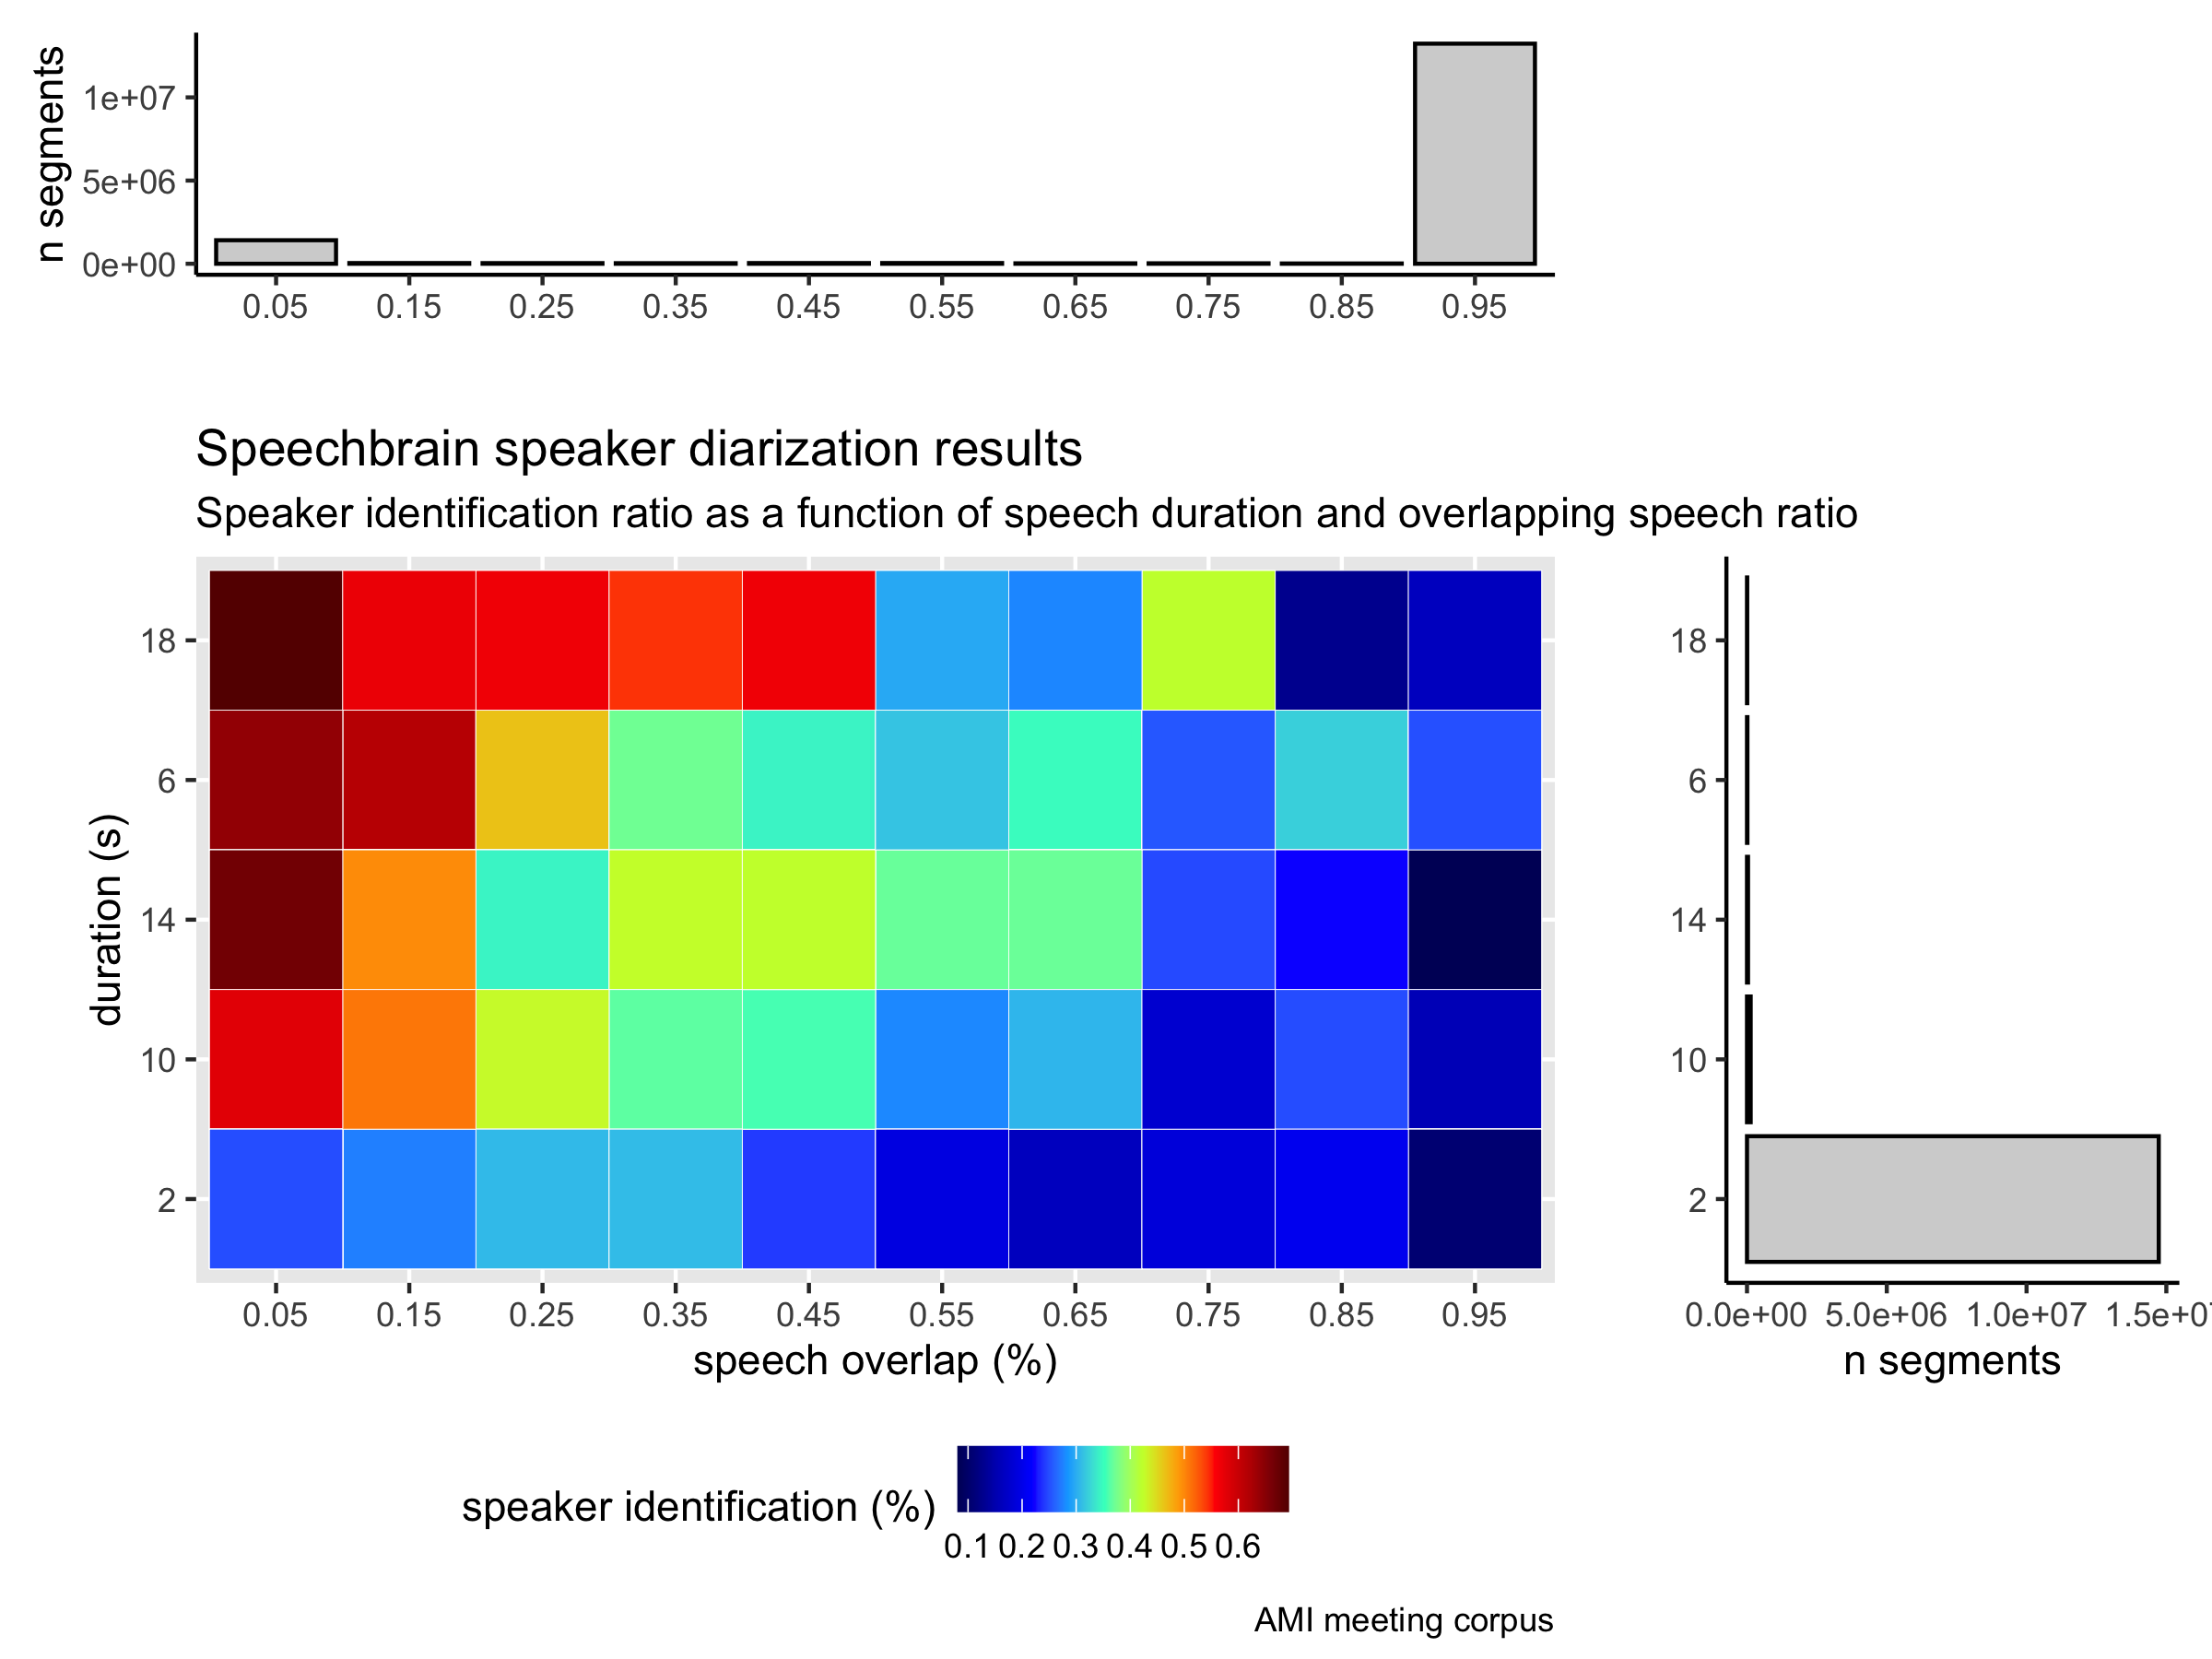

In [2]:
from IPython.display import Image
Image("/Users/evaviviani/github/mexca-sd-experiment/speaker-diarization/speechbrain_diarization_aggregatedResults.png")

The figure above shows the same pattern of results for all file IDs 

In [106]:
overlap_df.drop(columns=["duration_bins"]).to_csv("segment_identification.csv")

## Conclusion

Taken together, this experiment showed that the ECAPA-TDNN plus spectral clustering combination was the best for speaker turn represenation and clustering. This combination works especially well for longer segments with little overlap but worse for short, overlapping speech segments.